## Book chap. 9

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
print('Tensorflow version is', tf.__version__)

Tensorflow version is 2.6.0


In [16]:
# functions
FIGSIZE = (9, 6)

# for plotting
def plot_series(time, series, format='-', start=0, end=None):
    plt.figure(figsize=FIGSIZE)
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
# definiamo la serie temporale su cui lavoriamo
BASELINE = 10
SLOPE = 0.05
AMPLITUDE = 15
PERIOD = 365
NOISE_LEVEL = 6

time = np.arange(4*365+1, dtype="float32")

# time è un vett. numpy
def trend(time, slope=0.):
    return slope * time

def noise(time, noise_level=1., seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# seasonality
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
            np.cos(season_time*2*np.pi),
                    1./np.exp(3*season_time))

def seasonality(time, period, amplitude, phase=0.):
    season_time = ((time + phase) % period)/period
    return amplitude * seasonal_pattern(season_time)

def create_series(time):
    series = BASELINE + trend(time, slope=SLOPE) + seasonality(time, period=PERIOD, amplitude=AMPLITUDE) + noise(time, noise_level=NOISE_LEVEL, seed=42) 
    
    return series

In [17]:
# creo la serie temporale
series = create_series(time)

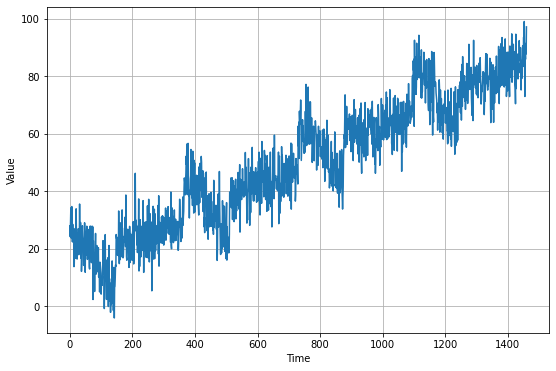

In [18]:
# grafico la serie
plot_series(time, series, format='-', start=0, end=None)

### Metriche

Quando sviluppiamo i modelli predittivi, possiamo usare MSE e MAE per valutare la bontà del modello

In [19]:
# computo metriche
def compute_metrics(y_actual, y_preds):
    mse = round(keras.metrics.mean_squared_error(y_actual, y_preds).numpy(), 3)
    mae = round(keras.metrics.mean_absolute_error(y_actual, y_preds).numpy(), 3)
    
    print('MSE è:', mse)
    print('MAE è:', mae)

    return mse, mae

### Modello1, Baseline: Naive forecast

In [20]:
### Modello 1: Naive Forecast
# La predizione al tempo t è il valore della serie a t -1

SPLIT_TIME = 1000

# valori attesi (LE PREVISIONI LE FACCIAMO SULL'INTERVALLO [SPLIT_TIME, END])
y_actual = series[SPLIT_TIME:]

# Predizioni del primo modello
naive_forecast = series[SPLIT_TIME - 1: -1]

In [21]:
mse, mae = compute_metrics(y_actual, naive_forecast)

MSE è: 76.468
MAE è: 6.9


### Modello 2: con moving average

In [22]:
WINDOW_SIZE = 30

def moving_avg_forecast(series, window_size):
    forecast = []
    
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
        
    return np.array(forecast)

In [23]:
mvg_avg_series = moving_avg_forecast(series, window_size=WINDOW_SIZE)[SPLIT_TIME - WINDOW_SIZE:]

In [24]:
mse, mae = compute_metrics(y_actual, mvg_avg_series)

MSE è: 47.563
MAE è: 5.44


In [12]:
### semplicemente facendo Moving Average ho ottenuto un miglioramento

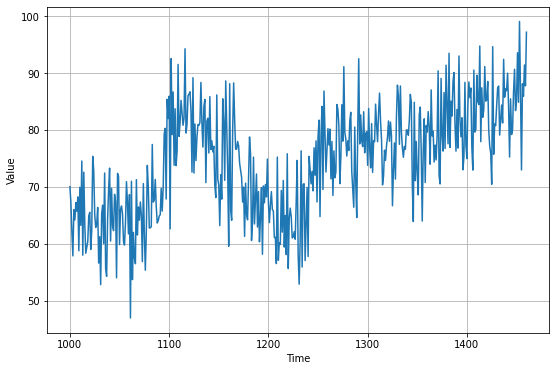

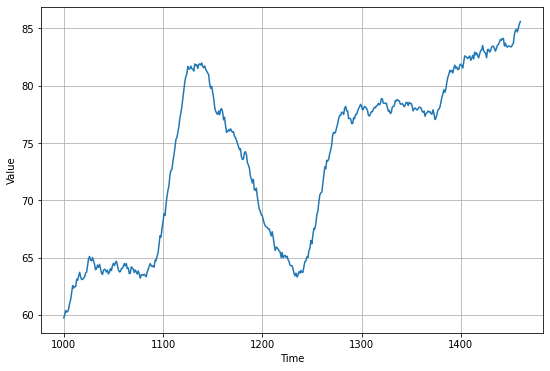

In [25]:
plot_series(time[SPLIT_TIME:], series[SPLIT_TIME:], format='-', start=0, end=None)
plot_series(time[SPLIT_TIME:], mvg_avg_series, format='-', start=0, end=None)

### Modello3: applico differencing per gestire la stagionalità

In sintesi, applico il moving average alla serie differenza

In [27]:
diff_series = series[PERIOD:] - series[PERIOD]
diff_time = time[PERIOD:]

In [28]:
diff_mvg_avg = moving_avg_forecast(diff_series, WINDOW_SIZE)